In [1]:
# Imports

import os
import shutil
from random import shuffle
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import plotly.express as px

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import torchvision
from torchvision import transforms as T
import pytorch_lightning as pl
from pytorch_lightning.metrics.classification import Accuracy, F1
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

In [2]:
# Getting our images in the right folders so we can use ImageFolder

project_path = os.getcwd().replace('/notebooks', '')
csv_path = project_path + '/data/HAM10000_metadata'
metadata = pd.read_csv(csv_path)

lesion_ids = metadata['lesion_id'].unique()
shuffle(lesion_ids)
lesion_ids = list(lesion_ids)

val_size = 0.15
test_size = 0.15

def set_membership(lesion_id):
    idx = lesion_ids.index(lesion_id)
    if idx < test_size*len(lesion_ids):
        return 'test'
    elif idx < (test_size+val_size)*len(lesion_ids):
        return 'val'
    else:
        return 'train'

for i in ['train', 'val', 'test']:
    path = project_path + '/data/images/' + i
    if not os.path.exists(path):
        os.mkdir(path)

for index, row in metadata.iterrows():
    destination_set = set_membership(row['lesion_id'])
    source = project_path + '/data/images/' + row['image_id'] + '.jpg'
    destination = project_path + '/data/images/' + destination_set + '/' + row['dx'] + '/' + row['image_id'] + '.jpg'
    destination_folder = project_path + '/data/images/' + destination_set + '/' + row['dx']
    if not os.path.exists(destination_folder):
        os.mkdir(destination_folder)
    if os.path.exists(source):
        shutil.move(source, destination)

In [3]:
# Setting up our dataloaders

labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

def estimate_weights_mfb(labels):
    frequencies = []
    for label in labels:
        count = len(metadata[metadata['dx'] == label]['dx'])
        frequencies.append(count)
    median_freq = np.median(frequencies)
    weights = [median_freq/freq for freq in frequencies]
    return weights

def sampler_weights(dataset, class_weights):
    weights = []
    for img, label in dataset:
        weights.append(class_weights[label])
    return torch.tensor(weights)

train_transform = T.Compose([
    T.ToTensor(),
    T.CenterCrop((448, 576)),
    T.Resize((112, 144)),
    T.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(90),
])

test_transform = T.Compose([
    T.ToTensor(),
    T.CenterCrop((448, 576)),
    T.Resize((112, 144)),
    T.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2)),
])

class_weights = estimate_weights_mfb(labels)

train_ds = torchvision.datasets.ImageFolder(project_path + '/data/images/train', transform=train_transform)
val_ds = torchvision.datasets.ImageFolder(project_path + '/data/images/val', transform=test_transform)
test_ds = torchvision.datasets.ImageFolder(project_path + '/data/images/test', transform=test_transform)
train_loader = DataLoader(train_ds, batch_size=32, num_workers=8, sampler=WeightedRandomSampler(sampler_weights(train_ds, class_weights), len(train_ds), replacement=True))
val_loader = DataLoader(val_ds, batch_size=32, num_workers=8, sampler=WeightedRandomSampler(sampler_weights(val_ds, class_weights), len(val_ds), replacement=True))
test_loader = DataLoader(test_ds, batch_size=32, num_workers=8, sampler=WeightedRandomSampler(sampler_weights(test_ds, class_weights), len(test_ds), replacement=True))

In [4]:
class Baseline(pl.LightningModule):
    def __init__(self, lr=1e-3, dropout=0.2):
        super().__init__()
        self.lr = lr
        self.accuracy = Accuracy()
        self.f1 = F1()

        self.NN = nn.Sequential(
            nn.Conv2d(3, 16, 5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout),
            nn.Conv2d(16, 32, 5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout),
            nn.Conv2d(32, 64, 5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout),
            nn.Conv2d(64, 64, 5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout),
            nn.Flatten(),
            nn.Linear(64*7*9, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 7)
        )

    def forward(self, x):
        return self.NN(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'val_loss'
        }

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self.NN(x)
        loss = F.cross_entropy(y_pred, y_true)
        self.log('train_loss', loss, prog_bar=False)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self.NN(x)
        loss = F.cross_entropy(y_pred, y_true.view(-1))
        acc = self.accuracy(torch.argmax(y_pred, dim=1), y_true.view(-1))
        f1 = self.f1(torch.argmax(y_pred, dim=1), y_true.view(-1))
        self.log('val_loss', loss, prog_bar=True)
        self.log('accuracy', acc, prog_bar=True)
        self.log('f1', f1, prog_bar=True)

In [5]:
# Init model and trainer

logger = CSVLogger("logs", name="LeNetLike", version='1.0')
callbacks = [
    EarlyStopping('accuracy', patience=5),
    LearningRateMonitor(logging_interval='step'),
    ]
trainer = pl.Trainer(gpus=1, auto_lr_find=False, max_epochs=20, logger=logger, callbacks=callbacks)
model = Baseline(lr=1e-3)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [6]:
# Optionally use lrfinder

# lr_finder = trainer.tuner.lr_find(model, train_loader, val_loader, update_attr=True)
# print(f'Suggested LR: {lr_finder.suggestion()}')
# fig = lr_finder.plot(suggest=True)
# fig.show()

In [7]:
# Train

trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ryan/anaconda3/envs/ml/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory logs/LeNetLike/1.0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name     | Type       | Params
----------------------------------------
0 | accuracy | Accuracy   | 0     
1 | f1       | F1         | 0     
2 | NN       | Sequential | 693 K 
----------------------------------------
693 K     Trainable params
0         Non-trainable params
693 K     Total params
2.774     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 267/267 [00:29<00:00,  8.94it/s, loss=0.7, v_num=1.0, val_loss=1.080, accuracy=0.629, f1=0.629]


In [8]:
# Visualize losses/metrics

log_dir = project_path + '/notebooks/logs/LeNetLike/1.0/'
log = pd.read_csv(os.path.join(log_dir, 'metrics.csv'))

train_log = log[['step', 'train_loss']].dropna().rename(columns={'train_loss': 'loss'})
train_log['set'] = 'train'
val_log = log[['step', 'val_loss']].dropna().rename(columns={'val_loss': 'loss'})
val_log['set'] = 'val'

log = train_log.append(val_log)
#log = train_log
log = log.sort_values(by=['step'])

fig = px.line(log, x='step', y='loss', color='set')
fig.show()

In [9]:
# Load a model we want to check out.

path = project_path + '/models/LeNetLike.pt'
#model.load_state_dict(torch.load(path))

<AxesSubplot:>

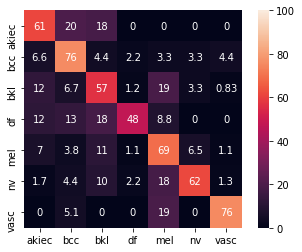

In [21]:
# Plot a confusion matrix

y_pred = []
y_true = []

# iterate over validation data
model.eval()
with torch.no_grad():
        for inputs, labels in val_loader:
                logits = model(inputs) # Feed Network

                output = (torch.max(torch.exp(logits), 1))[1].cpu().numpy()
                y_pred.extend(output) # Save Prediction
                
                labels = labels.data.cpu().numpy()
                y_true.extend(labels) # Save Truth

# constant for classes
classes = ('akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
norm_cf_matrix = np.zeros((7, 7))
for idx, row in enumerate(cf_matrix):
    row = row/row.sum()*100.0
    norm_cf_matrix[idx] = row
df_cm = pd.DataFrame(norm_cf_matrix, index = [i for i in classes], columns = [i for i in classes])
sns.heatmap(df_cm, annot=True, square=True, vmin=0.0, vmax=100.0)

In [11]:
# Save the model if we like it.

path = project_path + '/models/LeNetLike.pt'
#torch.save(model.state_dict(), path)